In [1]:
]activate ..

 Activating environment at `~/Developer/GenWorldModels.jl/examples/audio/Project.toml`


In [36]:
include("main.jl")

Main.AudioInference

In [37]:
using .AudioInference

In [38]:
trr = tones_with_noise(10.); nothing

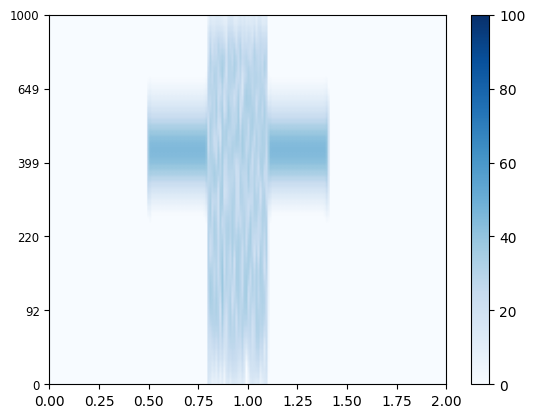

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa82b54a6d0>

In [39]:
vis_and_write_wave(trr, "trr.wav")

In [40]:
using Dates

In [41]:
#=
Outputs matrices where each column is a run for one initial trace,
and each row represents the ith iteration of each run.
=#
function get_times_and_likelihoods(initial_trs, run_inf!, iters)
    likelihoods = zeros(Float64, (iters, length(initial_trs)))
    times = zeros(Float64, (iters, length(initial_trs)))
    starttime = Dates.now()
    run_inf!(initial_trs[1], 20, (tr,) -> nothing) # compilation run
    for (i, initial_tr) in enumerate(initial_trs)
        print("Running trial $i...;")
        println(" $(Dates.now() - starttime) ms ellapsed in total")
        (l, t, record!) = AudioInference.get_worldmodel_likelihood_time_tracker_and_recorder()
        run_inf!(initial_tr, iters, record!)
        likelihoods[:, i] = l
        times[:, i] = t
    end
    return (times, likelihoods)
end

get_times_and_likelihoods (generic function with 1 method)

In [85]:
run_specs = Dict(
    :generic => (AudioInference.do_generic_inference, 1),
    :dumb_bd => (AudioInference.do_birth_death_inference, 1),
    :sumb_sm => (AudioInference.do_split_merge_inference, .6),
    :smart_bd => (AudioInference.do_smart_bd_inference, 1),
    :smart_bd_drift => (AudioInference.do_smart_bd_drift_inference, 1.7),
    :dumb_bd_drift => (AudioInference.do_dumb_birthdeath_drift_inference, 1.7),
    :smart_smbd => (AudioInference.do_smart_smbd_inference, .9),
    :smart_smbd_drift => (AudioInference.do_smart_drift_smbd_inference, 1.3)
)
nothing

In [60]:
function perform_runs(run_specs, initial_trs, num_generic_iters)
    times = Dict()
    likelihoods = Dict()
    
    for (label, (inf, num_iters_multiplier)) in run_specs
        n_iters = Int(floor(num_iters_multiplier*num_generic_iters))
        println("Running ", label, " for ", n_iters, " iterations per initial trace.")
        (t, l) = get_times_and_likelihoods(initial_trs, inf, n_iters)
        times[label] = t
        likelihoods[label] = l
    end
    
    return (times, likelihoods)
end

perform_runs (generic function with 1 method)

In [117]:
function plot_avg_times_and_likelihoods(times, likelihoods; POINT_SIZE=3, order=nothing, names=nothing, miny=nothing, maxx=nothing)
    key_itr = order === nothing ? keys(times) : order
    for label in key_itr
        t = times[label]
        l = likelihoods[label]
        avg_t = sum(t, dims=2) / size(t)[2]
        avg_l = sum(l, dims=2) / size(l)[2]
        name = names === nothing ? String(label) : names[label]
        scatter(avg_t, avg_l, label=name, s=POINT_SIZE)
    end
    if miny !== nothing
        ylim(bottom=miny)
    end
    if maxx !== nothing
        xlim(right=maxx)
    end
    xlabel("time (s)")
    ylabel("log likelihood of observed sound given inferred sources")
    title("Predictive log-likelihod of inferred audio sources over time")
    legend(loc="lower right")
end

plot_avg_times_and_likelihoods (generic function with 2 methods)

In [64]:
# merges the new times and likelihoods into the running ones (by concatenating to the
# matrix of run data)
# assumes that the same keys are 
function merge_in_runs!(running_times, running_likelihoods, new_times, new_likelihoods)
    for key in keys(running_times)
       running_times[key] = hcat(running_times[key], new_times[key])
       running_likelihoods[key] = hcat(running_likelihoods[key], new_times[key])
    end
end

merge_in_runs! (generic function with 1 method)

In [114]:
?ylim

search: ylim symlink




    Get or set the y-limits of the current axes.

    Call signatures::

        bottom, top = ylim()  # return the current ylim
        ylim((bottom, top))   # set the ylim to bottom, top
        ylim(bottom, top)     # set the ylim to bottom, top

    If you do not specify args, you can alternatively pass *bottom* or
    *top* as kwargs, i.e.::

        ylim(top=3)  # adjust the top leaving bottom unchanged
        ylim(bottom=1)  # adjust the bottom leaving top unchanged

    Setting limits turns autoscaling off for the y-axis.

    Returns
    -------
    bottom, top
        A tuple of the new y-axis limits.

    Notes
    -----
    Calling this function with no arguments (e.g. ``ylim()``) is the pyplot
    equivalent of calling `~.Axes.get_ylim` on the current axes.
    Calling this function with arguments is the pyplot equivalent of calling
    `~.Axes.set_ylim` on the current axes. All arguments are passed though.
    

In [86]:
NUM_RUNS_PER_EXPERIMENT = 4
initial_trs = [generate_initial_tr(trr)[1] for _=1:NUM_RUNS_PER_EXPERIMENT]
nothing

In [87]:
(t, l) = perform_runs(run_specs, initial_trs, 650)
nothing

Running smart_smbd_drift for 845 iterations per initial trace.
Running trial 1...; 685 milliseconds ms ellapsed in total
Running trial 2...; 28474 milliseconds ms ellapsed in total
Running trial 3...; 55451 milliseconds ms ellapsed in total
Running trial 4...; 85007 milliseconds ms ellapsed in total
Running smart_bd for 650 iterations per initial trace.
Running trial 1...; 866 milliseconds ms ellapsed in total
Running trial 2...; 21697 milliseconds ms ellapsed in total
Running trial 3...; 44829 milliseconds ms ellapsed in total
Running trial 4...; 69510 milliseconds ms ellapsed in total
Running dumb_bd_drift for 1105 iterations per initial trace.
Running trial 1...; 344 milliseconds ms ellapsed in total
Running trial 2...; 25706 milliseconds ms ellapsed in total
Running trial 3...; 50336 milliseconds ms ellapsed in total
Running trial 4...; 87751 milliseconds ms ellapsed in total
Running generic for 650 iterations per initial trace.
Running trial 1...; 1175 milliseconds ms ellapsed in 

In [88]:
running_times, running_likelihoods = (t, l)
nothing

In [98]:
for _=1:20
    try
        initial_trs = [generate_initial_tr(trr)[1] for _=1:4]
        (t, l) = perform_runs(run_specs, initial_trs, 650)
        merge_in_runs!(running_times, running_likelihoods, t, l)
    catch e
        continue;
    end
end

Running smart_smbd_drift for 845 iterations per initial trace.
Running trial 1...; 1930 milliseconds ms ellapsed in total
Running trial 2...; 26719 milliseconds ms ellapsed in total
Running trial 3...; 51211 milliseconds ms ellapsed in total
Running trial 4...; 82479 milliseconds ms ellapsed in total
Running smart_bd for 650 iterations per initial trace.
Running trial 1...; 764 milliseconds ms ellapsed in total
Running trial 2...; 24377 milliseconds ms ellapsed in total
Running trial 3...; 41336 milliseconds ms ellapsed in total
Running trial 4...; 64784 milliseconds ms ellapsed in total
Running dumb_bd_drift for 1105 iterations per initial trace.
Running trial 1...; 517 milliseconds ms ellapsed in total
Running trial 2...; 28372 milliseconds ms ellapsed in total
Running trial 3...; 55598 milliseconds ms ellapsed in total
Running trial 4...; 86630 milliseconds ms ellapsed in total
Running generic for 650 iterations per initial trace.
Running trial 1...; 491 milliseconds ms ellapsed in 

Running trial 4...; 58819 milliseconds ms ellapsed in total
Running sumb_sm for 390 iterations per initial trace.
Running trial 1...; 311 milliseconds ms ellapsed in total
Running trial 2...; 19978 milliseconds ms ellapsed in total
Running trial 3...; 39485 milliseconds ms ellapsed in total
Running trial 4...; 54404 milliseconds ms ellapsed in total
Running dumb_bd for 650 iterations per initial trace.
Running trial 1...; 298 milliseconds ms ellapsed in total
Running trial 2...; 24300 milliseconds ms ellapsed in total
Running trial 3...; 38235 milliseconds ms ellapsed in total
Running trial 4...; 59027 milliseconds ms ellapsed in total
Running smart_smbd for 585 iterations per initial trace.
Running trial 1...; 733 milliseconds ms ellapsed in total
Running trial 2...; 24432 milliseconds ms ellapsed in total
Running trial 3...; 47437 milliseconds ms ellapsed in total
Running trial 4...; 78325 milliseconds ms ellapsed in total
Running smart_bd_drift for 1105 iterations per initial trace.

Running trial 3...; 47173 milliseconds ms ellapsed in total
Running trial 4...; 65458 milliseconds ms ellapsed in total
Running smart_smbd_drift for 845 iterations per initial trace.
Running trial 1...; 545 milliseconds ms ellapsed in total
Running trial 2...; 24685 milliseconds ms ellapsed in total
Running trial 3...; 54216 milliseconds ms ellapsed in total
Running trial 4...; 84635 milliseconds ms ellapsed in total
Running smart_bd for 650 iterations per initial trace.
Running trial 1...; 840 milliseconds ms ellapsed in total
Running trial 2...; 26732 milliseconds ms ellapsed in total
Running trial 3...; 50437 milliseconds ms ellapsed in total
Running trial 4...; 73760 milliseconds ms ellapsed in total
Running dumb_bd_drift for 1105 iterations per initial trace.
Running trial 1...; 242 milliseconds ms ellapsed in total
Running trial 2...; 19789 milliseconds ms ellapsed in total
Running trial 3...; 43200 milliseconds ms ellapsed in total
Running trial 4...; 67135 milliseconds ms ellap

Running trial 2...; 25782 milliseconds ms ellapsed in total
Running trial 3...; 39972 milliseconds ms ellapsed in total
Running trial 4...; 57378 milliseconds ms ellapsed in total
Running sumb_sm for 390 iterations per initial trace.
Running trial 1...; 1076 milliseconds ms ellapsed in total
Running trial 2...; 23160 milliseconds ms ellapsed in total
Running trial 3...; 41283 milliseconds ms ellapsed in total
Running trial 4...; 57555 milliseconds ms ellapsed in total
Running dumb_bd for 650 iterations per initial trace.
Running trial 1...; 448 milliseconds ms ellapsed in total
Running trial 2...; 26747 milliseconds ms ellapsed in total
Running trial 3...; 41656 milliseconds ms ellapsed in total
Running trial 4...; 57604 milliseconds ms ellapsed in total
Running smart_smbd for 585 iterations per initial trace.
Running trial 1...; 750 milliseconds ms ellapsed in total
Running trial 2...; 20685 milliseconds ms ellapsed in total
Running trial 3...; 44881 milliseconds ms ellapsed in total


Running trial 1...; 442 milliseconds ms ellapsed in total
Running trial 2...; 31574 milliseconds ms ellapsed in total
Running trial 3...; 63634 milliseconds ms ellapsed in total
Running trial 4...; 85956 milliseconds ms ellapsed in total
Running smart_smbd_drift for 845 iterations per initial trace.
Running trial 1...; 548 milliseconds ms ellapsed in total
Running trial 2...; 24739 milliseconds ms ellapsed in total
Running trial 3...; 50734 milliseconds ms ellapsed in total
Running trial 4...; 64332 milliseconds ms ellapsed in total
Running smart_bd for 650 iterations per initial trace.
Running trial 1...; 740 milliseconds ms ellapsed in total
Running trial 2...; 21049 milliseconds ms ellapsed in total
Running trial 3...; 39782 milliseconds ms ellapsed in total
Running trial 4...; 62298 milliseconds ms ellapsed in total
Running dumb_bd_drift for 1105 iterations per initial trace.
Running trial 1...; 187 milliseconds ms ellapsed in total
Running trial 2...; 23619 milliseconds ms ellapse

Running generic for 650 iterations per initial trace.
Running trial 1...; 631 milliseconds ms ellapsed in total
Running trial 2...; 24802 milliseconds ms ellapsed in total
Running trial 3...; 40381 milliseconds ms ellapsed in total
Running trial 4...; 65128 milliseconds ms ellapsed in total
Running sumb_sm for 390 iterations per initial trace.
Running trial 1...; 957 milliseconds ms ellapsed in total
Running trial 2...; 21083 milliseconds ms ellapsed in total
Running trial 3...; 40160 milliseconds ms ellapsed in total
Running trial 4...; 59339 milliseconds ms ellapsed in total
Running dumb_bd for 650 iterations per initial trace.
Running trial 1...; 694 milliseconds ms ellapsed in total
Running trial 2...; 17552 milliseconds ms ellapsed in total
Running trial 3...; 38796 milliseconds ms ellapsed in total
Running trial 4...; 63919 milliseconds ms ellapsed in total
Running smart_smbd for 585 iterations per initial trace.
Running trial 1...; 882 milliseconds ms ellapsed in total
Running t

In [66]:
using PyPlot

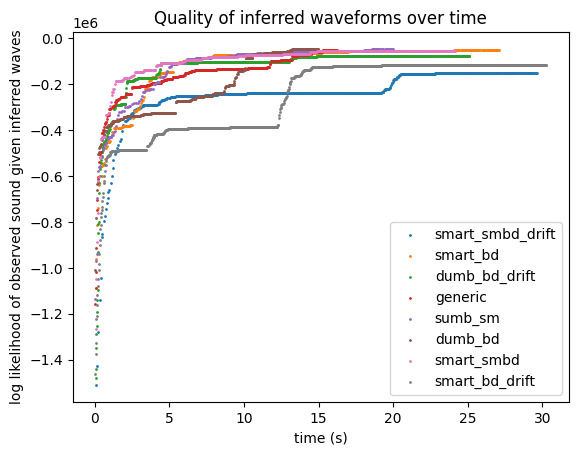

PyObject <matplotlib.legend.Legend object at 0x7fa80d35bd30>

In [72]:
plot_avg_times_and_likelihoods(t, l, POINT_SIZE=1)

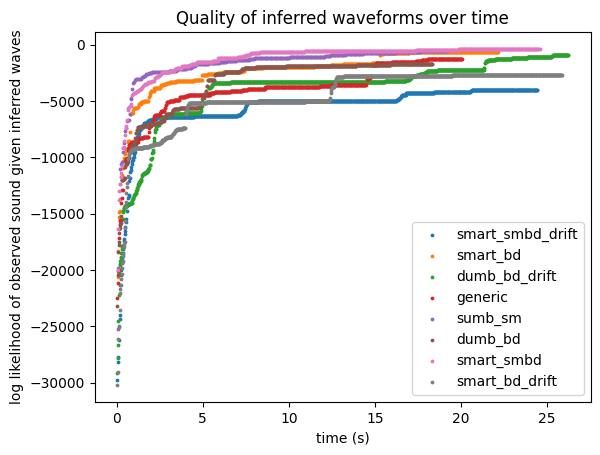

PyObject <matplotlib.legend.Legend object at 0x7fa80b59ce20>

In [100]:
plot_avg_times_and_likelihoods(running_times, running_likelihoods)

In [105]:
wanted_tags = [:smart_bd, :generic, :dumb_bd, :smart_smbd]
filt_t = Dict(t => running_times[t] for t in wanted_tags)
filt_l = Dict(t => running_likelihoods[t] for t in wanted_tags)

Dict{Symbol,Array{Float64,2}} with 4 entries:
  :smart_bd   => [-1.00388e6 -8.82124e5 … 0.048 0.039; -9.99658e5 -8.82124e5 … …
  :generic    => [-1.09112e6 -1.22152e6 … 0.04 0.05; -9.70297e5 -1.12257e6 … 0.…
  :dumb_bd    => [-7.7232e5 -1.4493e6 … 0.042 0.085; -7.41786e5 -1.28861e6 … 0.…
  :smart_smbd => [-1.02684e6 -7.77864e5 … 0.051 0.043; -1.02684e6 -6.1891e5 … 0…

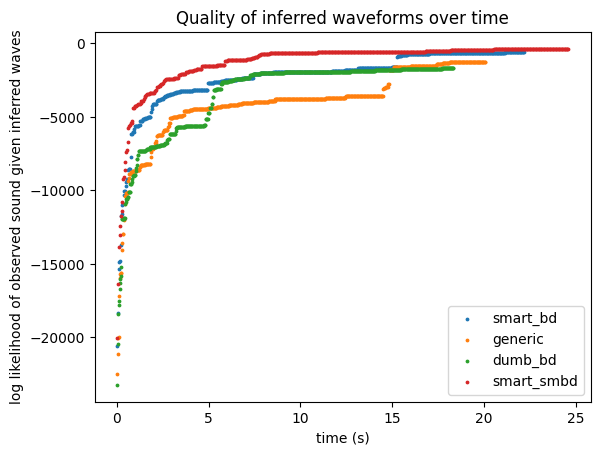

PyObject <matplotlib.legend.Legend object at 0x7fa80a29c700>

In [106]:
plot_avg_times_and_likelihoods(filt_t, filt_l)

In [122]:
names = Dict(
    :generic => "Ancestral resampling",
    :dumb_bd => "Generic birth/death",
    :smart_bd => "Data-driven custom birth/death",
    :smart_smbd => "Data-driven birth/death & split-merge"
)

Dict{Symbol,String} with 4 entries:
  :smart_bd   => "Data-driven custom birth/death"
  :generic    => "Ancestral resampling"
  :dumb_bd    => "Generic birth/death"
  :smart_smbd => "Data-driven birth/death & split-merge"

In [123]:
order = [:generic, :dumb_bd, :smart_bd, :smart_smbd]

4-element Array{Symbol,1}:
 :generic
 :dumb_bd
 :smart_bd
 :smart_smbd

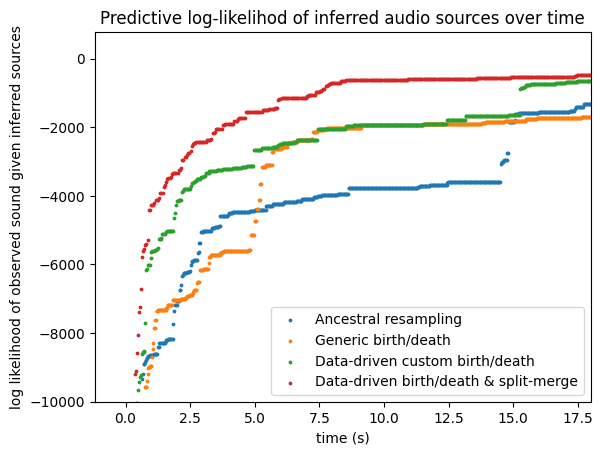

PyObject <matplotlib.legend.Legend object at 0x7fa82b3fe910>

In [124]:
plot_avg_times_and_likelihoods(filt_t, filt_l; order=order, names=names, maxx=18, miny=-10000)

In [130]:
function get_worldmodel_count_likelihood_time_tracker_and_recorder()
    counts = Int[]
    times = Float64[]
    starttime = Dates.now()
    function record_worldmodel_iter!(tr)
        push!(counts, tr[:kernel => :n_tones])
        push!(times, Dates.value(Dates.now() - starttime)/1000)
    end
    return (counts, times, record_worldmodel_iter!)
end

get_worldmodel_count_likelihood_time_tracker_and_recorder (generic function with 1 method)

In [144]:
#=
Outputs matrices where each column is a run for one initial trace,
and each row represents the ith iteration of each run.
=#
function get_times_and_counts(initial_trs, run_inf!, iters)
    counts = zeros(Int, (iters, length(initial_trs)))
    times = zeros(Float64, (iters, length(initial_trs)))
    starttime = Dates.now()
    run_inf!(initial_trs[1], 20, (tr,) -> nothing) # compilation run
    for (i, initial_tr) in enumerate(initial_trs)
        print("Running trial $i...;")
        println(" $(Dates.now() - starttime) ms ellapsed in total")
        (c, t, record!) = get_worldmodel_count_likelihood_time_tracker_and_recorder()
        run_inf!(initial_tr, iters, record!)
        counts[:, i] = c
        times[:, i] = t
    end
    return (times, counts)
end

get_times_and_counts (generic function with 1 method)

In [145]:
function perform_count_runs(run_specs, initial_trs, num_generic_iters)
    times = Dict()
    counts = Dict()
    
    for (label, (inf, num_iters_multiplier)) in run_specs
        n_iters = Int(floor(num_iters_multiplier*num_generic_iters))
        println("Running ", label, " for ", n_iters, " iterations per initial trace.")
        (t, c) = get_times_and_counts(initial_trs, inf, n_iters)
        times[label] = t
        counts[label] = c
    end
    
    return (times, counts)
end

perform_count_runs (generic function with 1 method)

In [ ]:
initial_trs = [generate_initial_tr(trr)[1] for _=1:50]
(t, c) = perform_count_runs(run_specs, initial_trs, 10)

Running smart_smbd_drift for 13 iterations per initial trace.
Running trial 1...; 938 milliseconds ms ellapsed in total
Running trial 2...; 1581 milliseconds ms ellapsed in total
Running trial 3...; 1981 milliseconds ms ellapsed in total
Running trial 4...; 2626 milliseconds ms ellapsed in total
Running trial 5...; 3711 milliseconds ms ellapsed in total
Running trial 6...; 4202 milliseconds ms ellapsed in total
Running trial 7...; 5110 milliseconds ms ellapsed in total
Running trial 8...; 5648 milliseconds ms ellapsed in total
Running trial 9...; 6165 milliseconds ms ellapsed in total
Running trial 10...; 6686 milliseconds ms ellapsed in total
Running trial 11...; 6989 milliseconds ms ellapsed in total
Running trial 12...; 7431 milliseconds ms ellapsed in total
Running trial 13...; 8283 milliseconds ms ellapsed in total
Running trial 14...; 9008 milliseconds ms ellapsed in total
Running trial 15...; 9562 milliseconds ms ellapsed in total
Running trial 16...; 9908 milliseconds ms ellaps

In [158]:
# counts = matrix, where each column has counts at each iter
# times = matrix, where each column has time at which each iter occurred
function get_count_to_time(times, counts)
    counts_to_time = [Set() for _=1:maximum(counts)]
    num_runs = size(times)[2]
    for run=1:num_runs
        t = times[:, run]
        c = counts[:, run]
        for i=1:length(t)
            i == 1 && continue
            Δt = t[i] - t[i-1]
            push!(counts_to_time[c[i]], Δt)
        end
    end
    return counts_to_time
end

get_count_to_time (generic function with 1 method)

In [161]:
label = :smart_smbd_drift
ctot = get_count_to_time(t[label], c[label])

3-element Array{Set{Any},1}:
 Set([0.037000000000000005, 0.068])
 Set([0.014999999999999958, 0.01699999999999996, 0.02899999999999997, 0.016000000000000014, 0.02300000000000002, 0.015000000000000013, 0.072, 0.017000000000000015, 0.019000000000000017, 0.018000000000000016, 0.018999999999999906, 0.020000000000000018, 0.01799999999999996])
 Set([0.022000000000000006, 0.016999999999999994])

In [170]:
reduce(+, ctot[1]; init=0.)

0.10500000000000001

In [ ]:
function get_counts_to_times(timesdict, countsdict)
    
end

In [177]:
function plot_count_to_avg_time(times, counts; POINT_SIZE=5, order=nothing, names=nothing)
    key_itr = order === nothing ? keys(times) : order
    for label in key_itr
        t = times[label]
        c = counts[label]
        count_to_time = get_count_to_time(t, c)
        count_to_avg_time = map(v -> reduce(+, v; init=0.)/length(v), count_to_time)
        plot(1:length(count_to_avg_time), count_to_avg_time, label=label)
    end
#     xlabel("time (s)")
#     ylabel("log likelihood of observed sound given inferred sources")
#     title("Predictive log-likelihod of inferred audio sources over time")
    legend(loc="lower right")
end

plot_count_to_avg_time (generic function with 1 method)

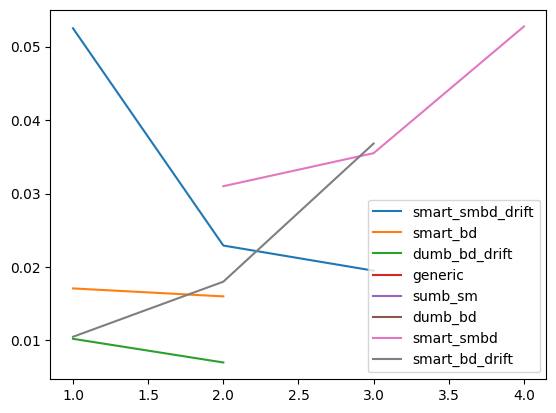

PyObject <matplotlib.legend.Legend object at 0x7fa809b8ba00>

In [178]:
plot_count_to_avg_time(t, c)

In [ ]:
filt_indices = Dict(
    
    for (k, t) in 
)

In [166]:
?reduce

search: reduce mapreduce



```
reduce(op, itr; [init])
```

Reduce the given collection `itr` with the given binary operator `op`. If provided, the initial value `init` must be a neutral element for `op` that will be returned for empty collections. It is unspecified whether `init` is used for non-empty collections.

For empty collections, providing `init` will be necessary, except for some special cases (e.g. when `op` is one of `+`, `*`, `max`, `min`, `&`, `|`) when Julia can determine the neutral element of `op`.

Reductions for certain commonly-used operators may have special implementations, and should be used instead: `maximum(itr)`, `minimum(itr)`, `sum(itr)`, `prod(itr)`,  `any(itr)`, `all(itr)`.

The associativity of the reduction is implementation dependent. This means that you can't use non-associative operations like `-` because it is undefined whether `reduce(-,[1,2,3])` should be evaluated as `(1-2)-3` or `1-(2-3)`. Use [`foldl`](@ref) or [`foldr`](@ref) instead for guaranteed left or right associativity.

Some operations accumulate error. Parallelism will be easier if the reduction can be executed in groups. Future versions of Julia might change the algorithm. Note that the elements are not reordered if you use an ordered collection.

# Examples

```jldoctest
julia> reduce(*, [2; 3; 4])
24

julia> reduce(*, [2; 3; 4]; init=-1)
-24
```

---

```
reduce(f, A; dims=:, [init])
```

Reduce 2-argument function `f` along dimensions of `A`. `dims` is a vector specifying the dimensions to reduce, and the keyword argument `init` is the initial value to use in the reductions. For `+`, `*`, `max` and `min` the `init` argument is optional.

The associativity of the reduction is implementation-dependent; if you need a particular associativity, e.g. left-to-right, you should write your own loop or consider using [`foldl`](@ref) or [`foldr`](@ref). See documentation for [`reduce`](@ref).

# Examples

```jldoctest
julia> a = reshape(Vector(1:16), (4,4))
4×4 Array{Int64,2}:
 1  5   9  13
 2  6  10  14
 3  7  11  15
 4  8  12  16

julia> reduce(max, a, dims=2)
4×1 Array{Int64,2}:
 13
 14
 15
 16

julia> reduce(max, a, dims=1)
1×4 Array{Int64,2}:
 4  8  12  16
```


In [99]:
running_times[:generic]

650×196 Array{Float64,2}:
  0.036   0.052   0.04    0.024   0.042  …   0.047   0.024   0.04    0.05
  0.077   0.071   0.057   0.031   0.071      0.085   0.062   0.072   0.064
  0.106   0.09    0.078   0.038   0.097      0.115   0.082   0.1     0.085
  0.125   0.11    0.111   0.05    0.115      0.15    0.105   0.156   0.103
  0.197   0.142   0.127   0.069   0.144      0.182   0.122   0.188   0.118
  0.217   0.165   0.143   0.095   0.166  …   0.237   0.143   0.22    0.133
  0.24    0.197   0.156   0.114   0.191      0.272   0.163   0.268   0.149
  0.261   0.219   0.17    0.144   0.223      0.309   0.185   0.301   0.168
  0.289   0.246   0.179   0.157   0.248      0.346   0.2     0.331   0.177
  0.307   0.278   0.199   0.172   0.288      0.377   0.24    0.361   0.199
  0.322   0.362   0.214   0.186   0.312  …   0.411   0.29    0.389   0.212
  0.341   0.425   0.226   0.198   0.334      0.45    0.329   0.418   0.229
  0.372   0.456   0.239   0.247   0.365      0.48    0.366   0.453   0.27
 

In [101]:
using Serialization

In [102]:
serialize("save.txt", running_times)

In [73]:
initial_trs = [generate_initial_tr(trr)[1] for _=1:2]
(t, l) = perform_runs(run_specs, initial_trs, 10)
nothing

Running smart_smbd_drift for 14 iterations per initial trace.
Running trial 1...; 778 milliseconds ms ellapsed in total
Running trial 2...; 1187 milliseconds ms ellapsed in total
Running smart_bd for 10 iterations per initial trace.
Running trial 1...; 1175 milliseconds ms ellapsed in total
Running trial 2...; 1686 milliseconds ms ellapsed in total
Running dumb_bd_drift for 20 iterations per initial trace.
Running trial 1...; 462 milliseconds ms ellapsed in total
Running trial 2...; 811 milliseconds ms ellapsed in total
Running generic for 10 iterations per initial trace.
Running trial 1...; 992 milliseconds ms ellapsed in total
Running trial 2...; 1651 milliseconds ms ellapsed in total
Running sumb_sm for 6 iterations per initial trace.
Running trial 1...; 1082 milliseconds ms ellapsed in total
Running trial 2...; 1268 milliseconds ms ellapsed in total
Running dumb_bd for 10 iterations per initial trace.
Running trial 1...; 764 milliseconds ms ellapsed in total
Running trial 2...; 124

(Dict{Any,Any}(:smart_smbd_drift => [0.057 0.034; 0.087 0.063; … ; 0.38 0.262; 0.409 0.282],:smart_bd => [0.06 0.043; 0.105 0.078; … ; 0.461 0.38; 0.508 0.505],:dumb_bd_drift => [0.054 0.038; 0.107 0.063; … ; 0.342 0.205; 0.347 0.211],:generic => [0.057 0.037; 0.12 0.069; … ; 0.617 0.342; 0.657 0.365],:sumb_sm => [0.041 0.066; 0.07 0.163; … ; 0.126 0.358; 0.185 0.399],:dumb_bd => [0.072 0.041; 0.106 0.076; … ; 0.433 0.23; 0.473 0.253],:smart_smbd => [0.073 0.065; 0.185 0.125; … ; 0.573 0.41; 0.638 0.46],:smart_bd_drift => [0.059 0.034; 0.099 0.059; … ; 0.532 0.384; 0.559 0.407]), Dict{Any,Any}(:smart_smbd_drift => [-2.1307801340100784e6 -1.396451908363496e6; -1.9061991578764434e6 -1.396451908363496e6; … ; -1.0310230419878433e6 -991138.8426096879; -970370.2847237488 -910472.9268416286],:smart_bd => [-1.6470581440844033e6 -871398.4706193351; -730629.8165339689 -802775.9871996215; … ; -530856.5244940252 -425806.4910383496; -476166.67867628887 -406283.48107621],:dumb_bd_drift => [-2.529917

In [79]:
rt, rl = t, l

(Dict{Any,Any}(:smart_smbd_drift => [0.071 0.034; 0.12 0.053; … ; 0.389 0.466; 0.415 0.491],:smart_bd => [0.098 0.03; 0.165 0.068; … ; 0.461 0.336; 0.489 0.405],:dumb_bd_drift => [0.066 0.023; 0.103 0.035; … ; 0.284 0.285; 0.29 0.296],:generic => [0.106 0.019; 0.15 0.027; … ; 0.266 0.124; 0.29 0.132],:sumb_sm => [0.08 0.039; 0.15 0.082; … ; 0.365 0.348; 0.422 0.412],:dumb_bd => [0.063 0.036; 0.109 0.06; … ; 0.38 0.394; 0.417 0.43],:smart_smbd => [0.066 0.047; 0.116 0.089; … ; 0.441 0.255; 0.491 0.276],:smart_bd_drift => [0.063 0.029; 0.111 0.049; … ; 0.728 0.308; 0.756 0.318]), Dict{Any,Any}(:smart_smbd_drift => [-3.216892983009465e6 -2.7896087207850134e6; -2.225879950010791e6 -2.58925382775645e6; … ; -954732.3186893351 -840807.1931002293; -884138.1426321606 -840765.4747862486],:smart_bd => [-974366.9808457704 -1.2762175234359966e6; -916231.5729730739 -871603.0608388134; … ; -641179.525747965 -754664.9525369036; -550894.0781458482 -754664.9525369036],:dumb_bd_drift => [-3.2055732508253

In [76]:
initial_trs = [generate_initial_tr(trr)[1] for _=1:2]
(t, l) = perform_runs(run_specs, initial_trs, 10)

Running smart_smbd_drift for 14 iterations per initial trace.
Running trial 1...; 716 milliseconds ms ellapsed in total
Running trial 2...; 1134 milliseconds ms ellapsed in total
Running smart_bd for 10 iterations per initial trace.
Running trial 1...; 1716 milliseconds ms ellapsed in total
Running trial 2...; 2207 milliseconds ms ellapsed in total
Running dumb_bd_drift for 20 iterations per initial trace.
Running trial 1...; 1427 milliseconds ms ellapsed in total
Running trial 2...; 1718 milliseconds ms ellapsed in total
Running generic for 10 iterations per initial trace.
Running trial 1...; 404 milliseconds ms ellapsed in total
Running trial 2...; 696 milliseconds ms ellapsed in total
Running sumb_sm for 6 iterations per initial trace.
Running trial 1...; 1362 milliseconds ms ellapsed in total
Running trial 2...; 1786 milliseconds ms ellapsed in total
Running dumb_bd for 10 iterations per initial trace.
Running trial 1...; 682 milliseconds ms ellapsed in total
Running trial 2...; 11

(Dict{Any,Any}(:smart_smbd_drift => [0.071 0.034; 0.12 0.053; … ; 0.389 0.466; 0.415 0.491],:smart_bd => [0.098 0.03; 0.165 0.068; … ; 0.461 0.336; 0.489 0.405],:dumb_bd_drift => [0.066 0.023; 0.103 0.035; … ; 0.284 0.285; 0.29 0.296],:generic => [0.106 0.019; 0.15 0.027; … ; 0.266 0.124; 0.29 0.132],:sumb_sm => [0.08 0.039; 0.15 0.082; … ; 0.365 0.348; 0.422 0.412],:dumb_bd => [0.063 0.036; 0.109 0.06; … ; 0.38 0.394; 0.417 0.43],:smart_smbd => [0.066 0.047; 0.116 0.089; … ; 0.441 0.255; 0.491 0.276],:smart_bd_drift => [0.063 0.029; 0.111 0.049; … ; 0.728 0.308; 0.756 0.318]), Dict{Any,Any}(:smart_smbd_drift => [-3.216892983009465e6 -2.7896087207850134e6; -2.225879950010791e6 -2.58925382775645e6; … ; -954732.3186893351 -840807.1931002293; -884138.1426321606 -840765.4747862486],:smart_bd => [-974366.9808457704 -1.2762175234359966e6; -916231.5729730739 -871603.0608388134; … ; -641179.525747965 -754664.9525369036; -550894.0781458482 -754664.9525369036],:dumb_bd_drift => [-3.2055732508253

In [80]:
merge_in_runs!(rt, rl, t, l)

In [83]:
for _=1:2
    initial_trs = [generate_initial_tr(trr)[1] for _=1:2]
    (t, l) = perform_runs(run_specs, initial_trs, 10)
    merge_in_runs!(rt, rl, t, l)
end

Running smart_smbd_drift for 14 iterations per initial trace.
Running trial 1...; 631 milliseconds ms ellapsed in total
Running trial 2...; 1100 milliseconds ms ellapsed in total
Running smart_bd for 10 iterations per initial trace.
Running trial 1...; 452 milliseconds ms ellapsed in total
Running trial 2...; 865 milliseconds ms ellapsed in total
Running dumb_bd_drift for 20 iterations per initial trace.
Running trial 1...; 433 milliseconds ms ellapsed in total
Running trial 2...; 588 milliseconds ms ellapsed in total
Running generic for 10 iterations per initial trace.
Running trial 1...; 575 milliseconds ms ellapsed in total
Running trial 2...; 706 milliseconds ms ellapsed in total
Running sumb_sm for 6 iterations per initial trace.
Running trial 1...; 784 milliseconds ms ellapsed in total
Running trial 2...; 992 milliseconds ms ellapsed in total
Running dumb_bd for 10 iterations per initial trace.
Running trial 1...; 707 milliseconds ms ellapsed in total
Running trial 2...; 862 mill

In [ ]:
(generic_times, generic_likelihoods) = get_avg_likelihoods(initial_trs), AudioInference.do_generic_inference, 180)
plot(generic_times, generic_likelihoods)

In [ ]:
(bd_times, bd_likelihoods) = get_avg_likelihoods(initial_trs, AudioInference.do_birth_death_inference, 200)
plot(bd_times, bd_likelihoods)

In [ ]:
(sm_times, sm_likelihoods) = get_avg_likelihoods(initial_trs, AudioInference.do_split_merge_inference, 100)
plot(sm_times, sm_likelihoods)

In [ ]:
(smart_bd_times, smart_bd_likelihoods) = get_avg_likelihoods(initial_trs, AudioInference.do_split_merge_inference, 100)

In [ ]:
TIME_CAP = 7.0
g_indices = filter(i -> generic_times[i] < TIME_CAP, 1:length(generic_times))
bd_indices = filter(i -> bd_times[i] < TIME_CAP, 1:length(bd_times))
sm_indices = filter(i -> sm_times[i] < TIME_CAP, 1:length(sm_times))
nothing

In [ ]:
POINT_SIZE = 8
scatter(generic_times[g_indices], generic_likelihoods[g_indices], label="generic", s=POINT_SIZE)
scatter(bd_times[bd_indices], bd_likelihoods[bd_indices], label="birth/death", s=POINT_SIZE)
scatter(sm_times[sm_indices], sm_likelihoods[sm_indices], label="split/merge", s=POINT_SIZE)
xlabel("time (s)")
ylabel("log likelihood of observed sound given inferred waves")
title("Quality of inferred waveforms over time")
legend(loc="lower right")

In [ ]:
(generic_times2, generic_likelihoods2) = get_avg_likelihoods(fill(initial_tr,20), AudioInference.do_generic_inference, 540)
plot(generic_times2, generic_likelihoods2)

In [ ]:
(bd_times2, bd_likelihoods2) = get_avg_likelihoods(fill(initial_tr,20), AudioInference.do_birth_death_inference, 600)
plot(bd_times2, bd_likelihoods2)

In [ ]:
(sm_times2, sm_likelihoods2) = get_avg_likelihoods(fill(initial_tr,20), AudioInference.do_split_merge_inference, 400)
plot(sm_times2, sm_likelihoods2)

In [ ]:
TIME_CAP = 30.0
g_indices2 = filter(i -> generic_times2[i] < TIME_CAP, 1:length(generic_times2))
bd_indices2 = filter(i -> bd_times2[i] < TIME_CAP, 1:length(bd_times2))
sm_indices2 = filter(i -> sm_times2[i] < TIME_CAP, 1:length(sm_times2))
nothing

In [ ]:
ax = gca()
ax[:set_ylim]([-400000, 0])
POINT_SIZE = 1
scatter(generic_times2[g_indices2], generic_likelihoods2[g_indices2], label="generic", s=POINT_SIZE)
scatter(bd_times2[bd_indices2], bd_likelihoods2[bd_indices2], label="birth/death", s=POINT_SIZE)
scatter(sm_times2[sm_indices2], sm_likelihoods2[sm_indices2], label="split/merge", s=POINT_SIZE)
xlabel("time (s)")
ylabel("log likelihood of observed sound given inferred waves")
title("Quality of inferred waveforms over time")
legend(loc="lower right")

In [ ]:
function get_avg_likelihoods(initial_trs, run_inf!, iters)
  likelihoods = zeros(Float64, iters)
  times = zeros(Float64, iters)
  starttime = Dates.now()
  run_inf!(initial_tr, 20, (tr,) -> nothing) # compilation run
  for (i, initial_tr) in enumerate(initial_trs)
    print("Running trial $i...;")
    println(" $(Dates.now() - starttime) ms ellapsed in total")
    (l, t, record!) = AudioInference.get_worldmodel_likelihood_time_tracker_and_recorder()
    run_inf!(initial_tr, iters, record!)
    likelihoods += l
    times += t
  end
  likelihoods /= length(initial_trs)
  times /= length(initial_trs)
  return (times, likelihoods)
end

In [ ]:
function get_avg_likelihoods_and_counts(initial_trs, run_inf!, iters)
  likelihoods = zeros(Float64, iters)
  counts = []
  starttime = Dates.now()
  for (i, initial_tr) in enumerate(initial_trs)
    print("Running trial $i...;")
    println(" $(Dates.now() - starttime) ms ellapsed in total")
    (l, record!) = AudioInference.get_worldmodel_likelihood_tracker_and_recorder()
    tr = run_inf!(initial_tr, iters, record!)
    push!(counts, tr[:kernel => :n_tones])
    likelihoods += l
  end
  likelihoods /= length(initial_trs)
  return (likelihoods, counts)
end

In [ ]:
(l, c) = get_avg_likelihoods_and_counts(fill(initial_tr,2), AudioInference.do_birth_death_inference, 600)
c

In [ ]:
(l, c) = get_avg_likelihoods_and_counts(fill(initial_tr,2), AudioInference.do_split_merge_inference, 600)
c

In [ ]:
using Pkg; Pkg.add("ProfileView")

In [ ]:
using Profile; using ProfileView;

In [ ]:
@profile get_avg_likelihoods_and_counts(fill(initial_tr,5), AudioInference.do_split_merge_inference, 600)

In [ ]:
ProfileView.view()

In [ ]:
function plot_gtg(gtg, duration, audio_sr, vmin, vmax;colors="Blues",plot_colorbar=false)
    
    max_freq=audio_sr/2
    imshow(gtg, cmap=colors, origin="lower", extent=(0, duration, 0, max_freq),vmin=vmin, vmax=vmax, aspect=1/1300)
    locs, labels = yticks();
    lowlim = AudioInference.freq_to_ERB(1.)
    hilim = AudioInference.freq_to_ERB(max_freq)
    fs = Int.(floor.(AudioInference.ERB_to_freq(range(lowlim, stop=hilim, length=length(locs)))))
    setp(gca().set_yticklabels(fs), fontsize="small")
    if plot_colorbar
        plt.colorbar()
    end
end

In [ ]:
function vis(tr)
    duration, _, sr, = AudioInference.get_args(tr)
    gram, scene_wave, = AudioInference.get_retval(tr)
  #  wavwrite(scene_wave/maximum(abs.(scene_wave)), title, Fs=sr)
 # display(gram)
    plot_gtg(gram, duration, sr, 0, 100)
end

In [ ]:
trr = tones_with_noise(10.); nothing

In [ ]:
vis(trr)

In [ ]:
tr = AudioInference.do_birth_death_inference(initial_tr, 500, (tr,) -> ())

In [ ]:
vis(tr)